# Reproject the ESA-CCI land cover map for Europe using the new reproject_dataset method

This notebook demonstrates the usage of the newly developed `xcube.core.resampling.reproject_dataset` function to reproject the ESA-CCI Land Cover Map of Europe. It serves a similar purpose as `xcube.core.resampling.resample_in_space`, but is significantly faster. 

Unlike the latter, which relies on the computationally expensive [Spatial Rectification Algorithm](https://xcube.readthedocs.io/en/latest/rectify.html#spatial-rectification-algorithm), this new method takes advantage of the regular structure of both the source and target grid mappings. This leads to a substantial speed-up and makes the approach highly scalable.

The notebook is structured into three parts:

1. Reprojecting the same ESA-CCI land cover area as in the notebook [reproject_esa_cci_landcover.ipynb](./reproject_esa_cci_landcover.ipynb) using the new method.
2. Comparing the results of the new and old methods to show their similarity.
3. Demonstrating potential issues with large chunk sizes when using the new reprojection method.

---
### 1. Reprojecting the same ESA-CCI land cover area as in the notebook reproject_esa_cci_landcover.ipynb using the new method.

In [1]:
from xcube.core.store import new_data_store
from xcube.core.resampling.reproject import reproject_dataset
from xcube.core.resampling import resample_in_space
from xcube.core.gridmapping import GridMapping
from datetime import datetime
import matplotlib.pyplot as plt
import pyproj
import numpy as np

We use the ESA CCI Land Cover map available from the [DeepESDL](https://www.earthsystemdatalab.net/) public S3 bucket. In the following cell, we access the multi-resolution dataset `"LC-1x2025x2025-2.0.0.levels"` and select the base level, which corresponds to the original spatial resolution of approximately 300 meters.

In [2]:
%%time
store = new_data_store("s3", root="deep-esdl-public")
mlds_lc = store.open_data("LC-1x2025x2025-2.0.0.levels")
ds = mlds_lc.base_dataset
ds

CPU times: user 170 ms, sys: 43.2 ms, total: 213 ms
Wall time: 975 ms


<xarray.Dataset> Size: 3TB
Dimensions:              (time: 31, lat: 64800, lon: 129600, bounds: 2)
Coordinates:
  * lat                  (lat) float64 518kB 90.0 90.0 89.99 ... -90.0 -90.0
  * lon                  (lon) float64 1MB -180.0 -180.0 -180.0 ... 180.0 180.0
  * time                 (time) datetime64[ns] 248B 1992-01-01 ... 2022-01-01
Dimensions without coordinates: bounds
Data variables:
    change_count         (time, lat, lon) uint8 260GB dask.array<chunksize=(1, 2025, 2025), meta=np.ndarray>
    crs                  int32 4B ...
    current_pixel_state  (time, lat, lon) float32 1TB dask.array<chunksize=(1, 2025, 2025), meta=np.ndarray>
    lat_bounds           (lat, bounds) float64 1MB dask.array<chunksize=(2025, 2), meta=np.ndarray>
    lccs_class           (time, lat, lon) uint8 260GB dask.array<chunksize=(1, 2025, 2025), meta=np.ndarray>
    lon_bounds           (lon, bounds) float64 2MB dask.array<chunksize=(2025, 2), meta=np.ndarray>
    observation_count    (time, lat, lon) uint16 521GB dask.array<chunksize=(1, 2025, 2025), meta=np.ndarray>
    processed_flag       (time, lat, lon) float32 1TB dask.array<chunksize=(1, 2025, 2025), meta=np.ndarray>
    time_bounds          (time, bounds) datetime64[ns] 496B dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    time_coverage_end:          19921231
    time_coverage_resolution:   P1Y
    time_coverage_start:        19920101
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y

To follow the same example and be comparibale with the example shown in reproject_esa_cci_landcover.ipynb, we select the same years and the spatial extend. 

In [3]:
%%time
ds_cut = ds.sel(
    time=slice(datetime(2018, 1, 1), datetime(2022, 1, 1)),
    lat=slice(85, 25),
    lon=slice(-20, 40),
)
ds_cut

CPU times: user 21.7 ms, sys: 5.05 ms, total: 26.8 ms
Wall time: 25.7 ms


<xarray.Dataset> Size: 28GB
Dimensions:              (time: 5, lat: 21600, lon: 21600, bounds: 2)
Coordinates:
  * lat                  (lat) float64 173kB 85.0 85.0 84.99 ... 25.01 25.0 25.0
  * lon                  (lon) float64 173kB -20.0 -20.0 -19.99 ... 40.0 40.0
  * time                 (time) datetime64[ns] 40B 2018-01-01 ... 2022-01-01
Dimensions without coordinates: bounds
Data variables:
    change_count         (time, lat, lon) uint8 2GB dask.array<chunksize=(1, 225, 1125), meta=np.ndarray>
    crs                  int32 4B ...
    current_pixel_state  (time, lat, lon) float32 9GB dask.array<chunksize=(1, 225, 1125), meta=np.ndarray>
    lat_bounds           (lat, bounds) float64 346kB dask.array<chunksize=(225, 2), meta=np.ndarray>
    lccs_class           (time, lat, lon) uint8 2GB dask.array<chunksize=(1, 225, 1125), meta=np.ndarray>
    lon_bounds           (lon, bounds) float64 346kB dask.array<chunksize=(1125, 2), meta=np.ndarray>
    observation_count    (time, lat, lon) uint16 5GB dask.array<chunksize=(1, 225, 1125), meta=np.ndarray>
    processed_flag       (time, lat, lon) float32 9GB dask.array<chunksize=(1, 225, 1125), meta=np.ndarray>
    time_bounds          (time, bounds) datetime64[ns] 80B dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    time_coverage_end:          19921231
    time_coverage_resolution:   P1Y
    time_coverage_start:        19920101
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y

Next we can lot the selected extent for the year 2022.

CPU times: user 1.45 s, sys: 317 ms, total: 1.76 s
Wall time: 6.52 s


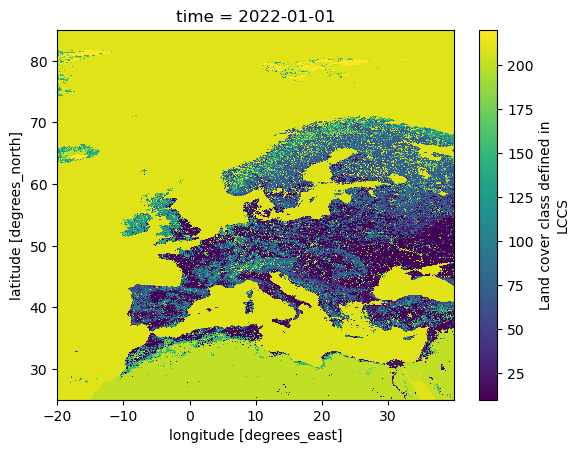

In [4]:
%%time
ds_cut.lccs_class.isel(time=-1)[::10, ::10].plot()

We generate a grid mapping in the desired CRS by transforming the source grid mapping and making it regular. The resulting grid mapping will be used for the reprojection in the following cell. 

In [5]:
%%time
source_gm = GridMapping.from_dataset(ds_cut, tile_size=1024)
temp_target_gm = source_gm.transform("EPSG:3035", xy_res=300)
target_gm = temp_target_gm.to_regular()
target_gm

CPU times: user 723 ms, sys: 47.9 ms, total: 771 ms
Wall time: 752 ms


class: **RegularGridMapping**
* is_regular: True
* is_j_axis_up: False
* is_lon_360: False
* crs: EPSG:3035
* xy_res: (300, 300)
* xy_bbox: (1287527, 239402, 7354727, 6907202)
* ij_bbox: (0, 0, 20224, 22226)
* xy_dim_names: ('x', 'y')
* xy_var_names: ('x', 'y')
* size: (20224, 22226)
* tile_size: (1024, 1024)

In [6]:
%%time
ds_reproject = reproject_dataset(
    ds_cut,
    target_gm=target_gm
)
ds_reproject

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7eb4635fb380>>
Traceback (most recent call last):
  File "/home/konstantin/micromamba/envs/xcube/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 

KeyboardInterrupt



In [7]:
%%time
ds_reproject.lccs_class.isel(time=-1)[::10, ::10].plot()

NameError: name 'ds_reproject' is not defined

The reprojection method can work with any size of the source dataset. It will just select the uperlapping chunks of the source datasets whihc overlaps with the target gridmapping. If clipping is applied and the target gridmapping exceeds the boudaries of the source dataset, padding with the fill value needs to be applied. If this is not neessary the code is fasterm, as shown in the next cell.

In [ ]:
%%time
ds_reproject = reproject_dataset(
    ds,
    source_gm=source_gm,
    target_gm=target_gm
)
ds_reproject

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7eb4635fb380>>
Traceback (most recent call last):
  File "/home/konstantin/micromamba/envs/xcube/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7eb4635fb380>>
Traceback (most recent call last):
  File "/home/konstantin/micromamba/envs/xcube/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:
%%time
ds_reproject.lccs_class.isel(time=-1)[::10, ::10].plot()

---
## 2. Comparing the results of the new and old methods to show their similarity

We generate a regular grid mapping covering Germany and demonstrate that the new `reproject_dataset` method produces results very similar to those of the `resample_in_space` method. 

As a first step, we create a regular grid mapping using the EPSG:3035 coordinate reference system.

In [4]:
%%time
bbox = [8, 49, 13, 54]
target_crs = "EPSG:3035"
t = pyproj.Transformer.from_crs("EPSG:4326", target_crs, always_xy=True)
target_bbox = t.transform_bounds(*bbox)
spatial_res = 150
x_size = int((target_bbox[2] - target_bbox[0]) / spatial_res) + 1
y_size = int(abs(target_bbox[3] - target_bbox[1]) / spatial_res) + 1
target_gm = GridMapping.regular(
    size=(x_size, y_size),
    xy_min=(target_bbox[0] - spatial_res / 2, target_bbox[1] - spatial_res / 2),
    xy_res=spatial_res,
    crs=target_crs,
    tile_size=2000,
)

CPU times: user 79 ms, sys: 7.12 ms, total: 86.1 ms
Wall time: 83.7 ms


First, we apply the new `reproject_dataset` method.

In [5]:
%%time
ds_reproject = reproject_dataset(ds, target_gm=target_gm)
ds_reproject

CPU times: user 675 ms, sys: 11.5 ms, total: 687 ms
Wall time: 683 ms


<xarray.Dataset> Size: 7MB
Dimensions:      (time: 3, x: 1220, y: 1868)
Coordinates:
  * time         (time) datetime64[ns] 24B 2020-01-01 2021-01-01 2022-01-01
  * x            (x) float64 10kB 4.175e+06 4.175e+06 ... 4.54e+06 4.54e+06
  * y            (y) float64 15kB 3.436e+06 3.436e+06 ... 2.877e+06 2.876e+06
    spatial_ref  int64 8B 0
Data variables:
    lccs_class   (time, y, x) uint8 7MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    time_coverage_end:          19921231
    time_coverage_resolution:   P1Y
    time_coverage_start:        19920101
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y

Secondly, we apply the exsisting `resample_in_space` method, where we clip the source dataset. Otherwise, `resampling_in_space` would take for ever. 

In [ ]:
%%time
ds_clip = ds.sel(lon=slice(5, 16), lat=slice(57, 46))
ds_resampling = resample_in_space(ds_clip, target_gm=target_gm)
ds_resampling

Lastly, we plot the reprojected land cover classification for both methods and the difference between them. 

CPU times: user 1.98 s, sys: 342 ms, total: 2.32 s
Wall time: 1.59 s


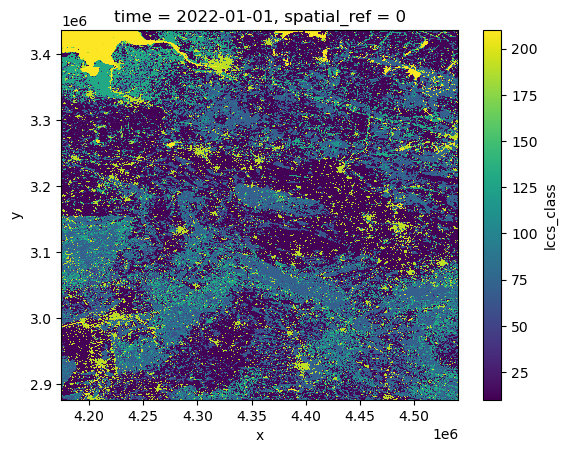

In [6]:
%%time
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ds_reproject.lccs_class.isel(time=-1).plot(ax=ax[0])
ds_resampling.lccs_class.isel(time=-1).plot(ax=ax[1])
diff = ds_resampling.lccs_class.isel(time=-1) - ds_reproject.lccs_class.isel(time=-1)
diff = diff.where(diff != 0, np.nan)
diff.plot(ax=ax[2])